# Gradient Booster | Datensatz ohne `service`

- **Gradient Booster** ist eine ensemblebasierte Methode, was bedeutet, dass es mehrere einfache Modelle (in der Regel Entscheidungsbäume) kombiniert, um bessere Vorhersagen zu treffen. Die Grundidee besteht darin, dass aufeinanderfolgende Modelle die Fehler der vorherigen Modelle korrigieren. Beim Gradient Boosting wird dies erreicht, indem die Residuen (Fehler) der Vorhersagen minimiert werden, indem neue Modelle in Richtung des Gradienten (Ableitung) des Fehlers trainiert werden.

1. Ensemble-Methode: Es kombiniert mehrere schwache Modelle (Entscheidungsbäume).
2. Additives Modell: Neue Modelle werden hinzugefügt, um die Vorhersage zu verbessern, indem sie auf die Fehler der vorherigen Modelle optimiert werden.
3. Gradientenabstieg: Es verwendet Gradientenabstieg, um die Fehler zu minimieren, was das Modell iterativ besser macht.

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# GeoJSON-Datei laden
gdf = gpd.read_file('../../data/processed_data/simra_osm_no_service_all.geojson')

In [8]:
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])
df.head(2)

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,tertiary,track
0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0
1,0.0,30,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0


In [5]:
# Features und Zielvariable trennen
X = df.drop(columns='score')
y = df['score']

In [6]:
# Aufteilen in Trainings-, Validierungs- und Testmengen (60% Training, 20% Validation, 20% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# GradientBoostingRegressor-Modell erstellen
gbr = GradientBoostingRegressor(random_state=1)

In [8]:
# Hyperparameter-Raster für GridSearchCV
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [12]:
# GridSearchCV einrichten (5-fache Cross-Validation auf Trainingsmenge)
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [15]:
# Modelltraining mit GridSearchCV auf der skalierten Trainingsmenge
grid_search_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
# Bestes Modell und Parameter
best_gbr_params = grid_search_gbr.best_params_
best_gbr_model = grid_search_gbr.best_estimator_

print(f"Best Score: {grid_search_gbr.best_score_}")
print(f"Best Params: {grid_search_gbr.best_params_}")

Best Score: -0.0019048191297581323
Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [20]:
# Evaluierung des Gradient Boosting Modells auf der skalierten Validierungs- und Testmenge
y_valid_gbr_pred = best_gbr_model.predict(X_valid)
y_test_gbr_pred = best_gbr_model.predict(X_test)

In [21]:
# Fehlermetriken für Validierungsmenge berechnen
mse_valid_gbr = mean_squared_error(y_valid, y_valid_gbr_pred)
rmse_valid_gbr = np.sqrt(mse_valid_gbr)
mae_valid_gbr = mean_absolute_error(y_valid, y_valid_gbr_pred)
r2_valid_gbr = r2_score(y_valid, y_valid_gbr_pred)

# Fehlermetriken für Testmenge berechnen
mse_test_gbr = mean_squared_error(y_test, y_test_gbr_pred)
rmse_test_gbr = np.sqrt(mse_test_gbr)
mae_test_gbr = mean_absolute_error(y_test, y_test_gbr_pred)
r2_test_gbr = r2_score(y_test, y_test_gbr_pred)

# Ausgabe der Fehlermetriken für GradientBoostingRegressor
print(f'GradientBoostingRegressor MSE Validierungsmenge: {mse_valid_gbr:.4f}, Testmenge: {mse_test_gbr:.4f}')
print(f'GradientBoostingRegressor RMSE Validierungsmenge: {rmse_valid_gbr:.4f}, Testmenge: {rmse_test_gbr:.4f}')
print(f'GradientBoostingRegressor MAE Validierungsmenge: {mae_valid_gbr:.4f}, Testmenge: {mae_test_gbr:.4f}')
print(f'GradientBoostingRegressor R² Validierungsmenge: {r2_valid_gbr:.4f}, Testmenge: {r2_test_gbr:.4f}')

GradientBoostingRegressor MSE Validierungsmenge: 0.0017, Testmenge: 0.0019
GradientBoostingRegressor RMSE Validierungsmenge: 0.0406, Testmenge: 0.0440
GradientBoostingRegressor MAE Validierungsmenge: 0.0156, Testmenge: 0.0150
GradientBoostingRegressor R² Validierungsmenge: 0.0037, Testmenge: -0.0014


# Version 2

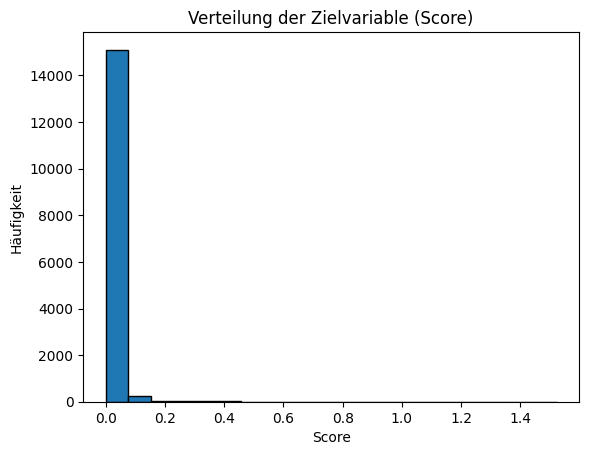

In [9]:
import matplotlib.pyplot as plt

# Verteilung der Zielvariable (score)
plt.hist(df['score'], bins=20, edgecolor='black')
plt.title('Verteilung der Zielvariable (Score)')
plt.xlabel('Score')
plt.ylabel('Häufigkeit')
plt.show()

- der Wert 0 kommt im Vergleich zu anderen Werten in der Zielvariable mit Abstand am häufigsten vor

### Datenaufbereitung und Training

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Features (X) und Zielvariable (y) definieren
X = df.drop(columns=['score'])  # Alle Spalten außer der Zielvariable
y = df['score']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalieren der Daten (nur die numerischen Spalten)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Gradient Boosting Regressor Modell
gbr = GradientBoostingRegressor()

# Modell trainieren
gbr.fit(X_train_scaled, y_train)

# Vorhersagen treffen
y_pred_train = gbr.predict(X_train_scaled)
y_pred_test = gbr.predict(X_test_scaled)

# Modellbewertung
print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print("Test R²:", r2_score(y_test, y_pred_test))

Train MSE: 0.0018164963256269008
Test MSE: 0.0016279084563360178
Test R²: -0.00283889973566942


### 3. Optimierung der Hyperparameter mit GridSearchCV 

#### Optimierungsvorschläge:
1. Zielvariable balancieren (Optional: Stratified Sampling):

Wenn du das Verhältnis von Null-Werten und nicht-Null-Werten verbessern möchtest, kannst du die Verteilung der Zielvariablen durch Resampling verbessern:

In [4]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
